<h3 align="center" style='color:blue'>Optimize tensorflow pipeline performance with prefetch and caching</h3>

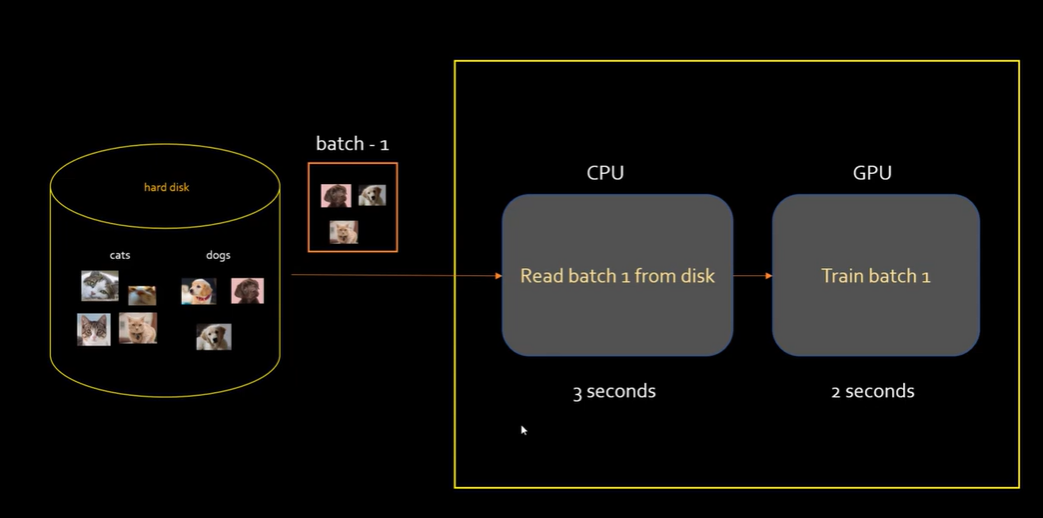

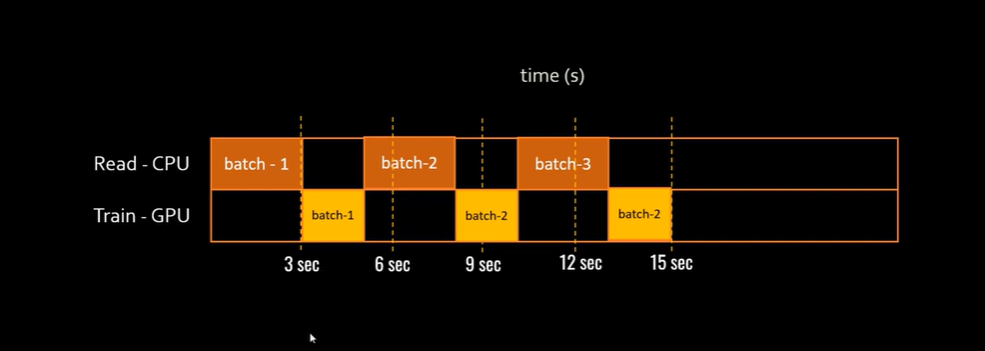

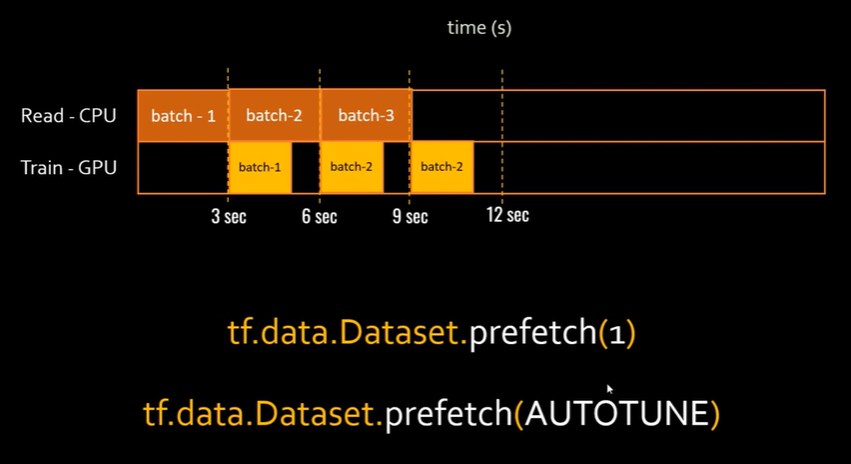

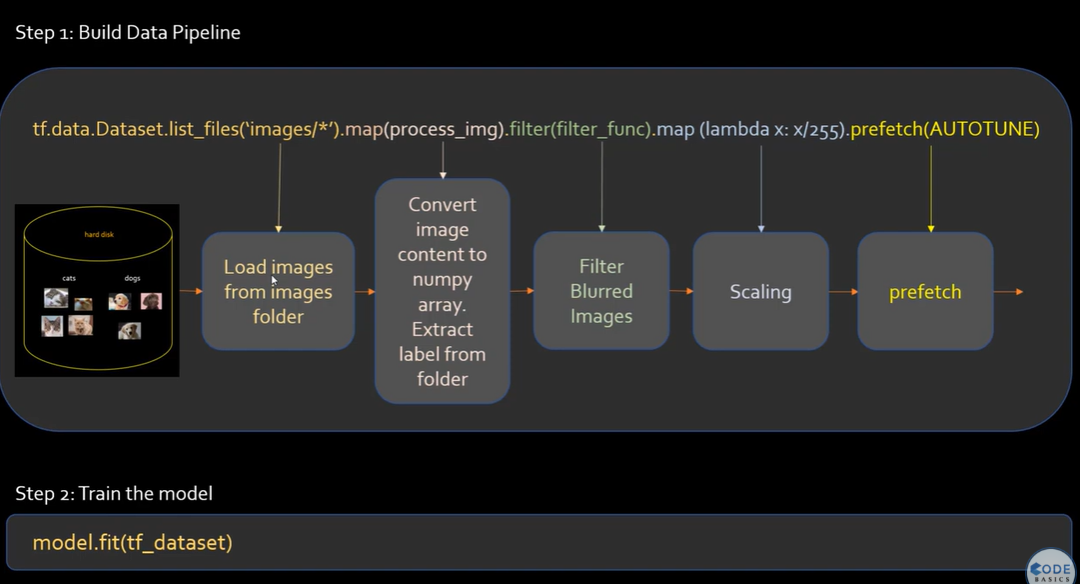

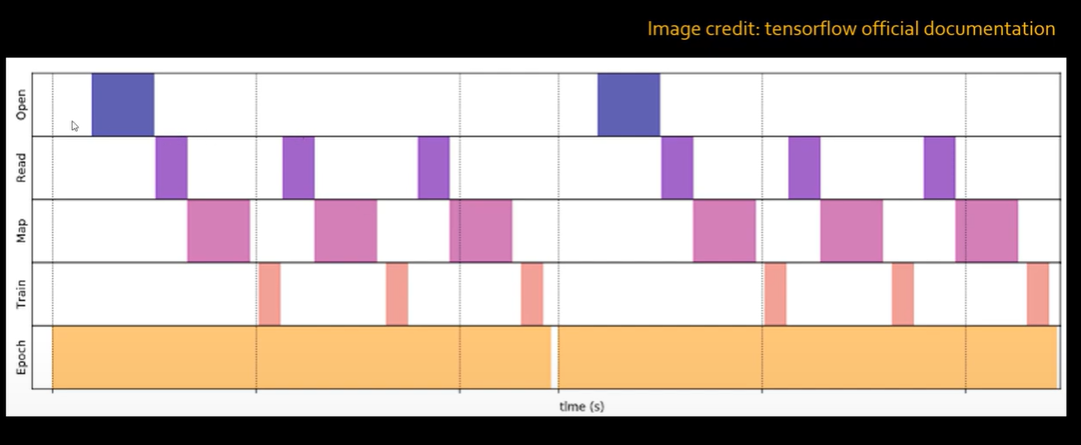

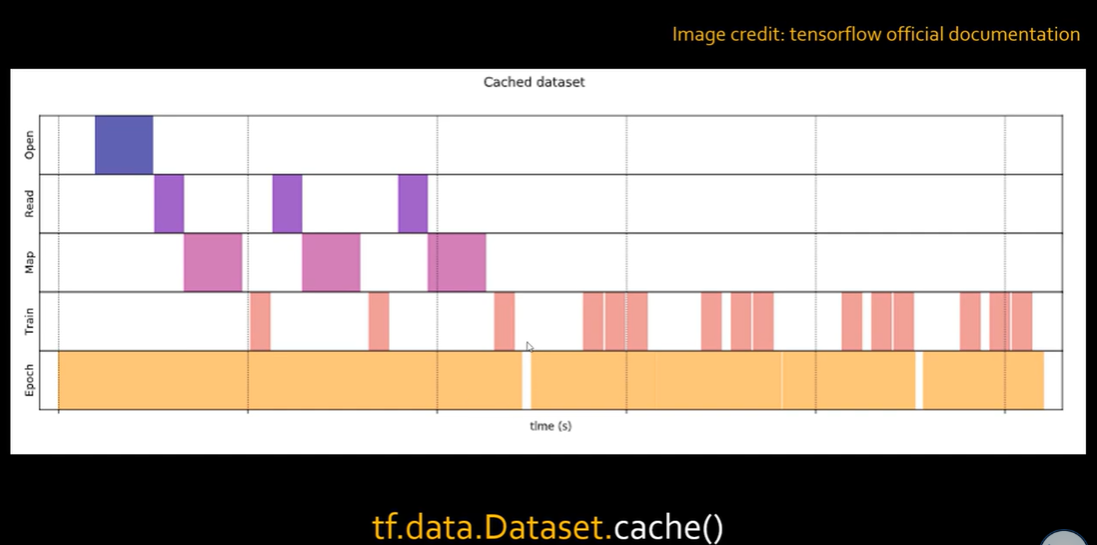

In [ ]:
import tensorflow as tf
import time

In [ ]:
tf.__version__

'2.5.0'

<h3 style='color:purple'>Prefetch</h3>

In [ ]:
class FileDataset(tf.data.Dataset):
    def read_file_in_batches(num_samples):
        # Opening the file
        time.sleep(0.03)

        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            time.sleep(0.015)

            yield (sample_idx,)

    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls.read_file_in_batches,
            output_signature = tf.TensorSpec(shape = (1,), dtype = tf.int64),
            args=(num_samples,)
        )

In [ ]:
def benchmark(dataset, num_epochs=2):
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(0.01)

In [ ]:
%%timeit
benchmark(FileDataset())

304 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
benchmark(FileDataset().prefetch(1))

238 ms ± 6.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
benchmark(FileDataset().prefetch(tf.data.AUTOTUNE))

240 ms ± 7.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**As you can notice above, using prefetch improves the performance from 304 ms to 238 and 240 ms**

<h3 style='color:purple'>Cache</h3>

In [ ]:
dataset = tf.data.Dataset.range(5)
dataset = dataset.map(lambda x: x**2)
dataset = dataset.cache("mycache.txt")
# The first time reading through the data will generate the data using
# `range` and `map`.
list(dataset.as_numpy_iterator())

[0, 1, 4, 9, 16]

In [ ]:
# Subsequent iterations read from the cache.
list(dataset.as_numpy_iterator())

[0, 1, 4, 9, 16]

In [ ]:
def mapped_function(s):
    # Do some hard pre-processing
    tf.py_function(lambda: time.sleep(0.03), [], ())
    return s

In [ ]:
%%timeit -r1 -n1
benchmark(FileDataset().map(mapped_function), 5)

1.25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
%%timeit -r1 -n1
benchmark(FileDataset().map(mapped_function).cache(), 5)

528 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


**Further reading** https://www.tensorflow.org/guide/data_performance#caching